In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [ ]:
from plotly import graph_objs as go
import plotly.express as px
import plotly.figure_factory as ff
from collections import Counter

from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Embedding, LSTM, Dense,SpatialDropout1D, Dropout, Bidirectional, BatchNormalization, Input, GRU, Attention
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam, AdamW, RMSprop

from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split

import nltk
from nltk.corpus import stopwords
import re


from transformers import BertTokenizer, BertModel
import torch
from tensorflow.keras.regularizers import l2

In [ ]:
%%capture
!pip install imbalanced-learn

In [ ]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
tweet_df = pd.read_csv('./twitter_training.csv', header=None)

In [ ]:
tweet_df.drop(columns=[0,1], axis=1, inplace=True)

In [ ]:
tweet_df.columns = ['sentiment', 'text']

In [ ]:
tweet_df.head()

sentiment                                               text
0  Positive  im getting on borderlands and i will murder yo...
1  Positive  I am coming to the borders and I will kill you...
2  Positive  im getting on borderlands and i will kill you ...
3  Positive  im coming on borderlands and i will murder you...
4  Positive  im getting on borderlands 2 and i will murder ...

In [ ]:
tweet_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74682 entries, 0 to 74681
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   sentiment  74682 non-null  object
 1   text       73996 non-null  object
dtypes: object(2)
memory usage: 1.1+ MB


In [ ]:
tweet_df.isnull().sum()

sentiment      0
text         686
dtype: int64

In [ ]:
tweet_df.dropna(inplace=True)

In [ ]:
tweet_df['sentiment'].value_counts(normalize=True)*100

sentiment
Negative      30.215147
Positive      27.913671
Neutral       24.471593
Irrelevant    17.399589
Name: proportion, dtype: float64

In [ ]:
tweet_df['sentiment'] = tweet_df['sentiment'].map({ 'Negative' : 0 ,  'Positive' : 1,  'Neutral' : 2,  'Irrelevant' : 3})

In [ ]:
tweet_df.head()

sentiment                                               text
0          1  im getting on borderlands and i will murder yo...
1          1  I am coming to the borders and I will kill you...
2          1  im getting on borderlands and i will kill you ...
3          1  im coming on borderlands and i will murder you...
4          1  im getting on borderlands 2 and i will murder ...

<Axes: xlabel='sentiment', ylabel='count'>

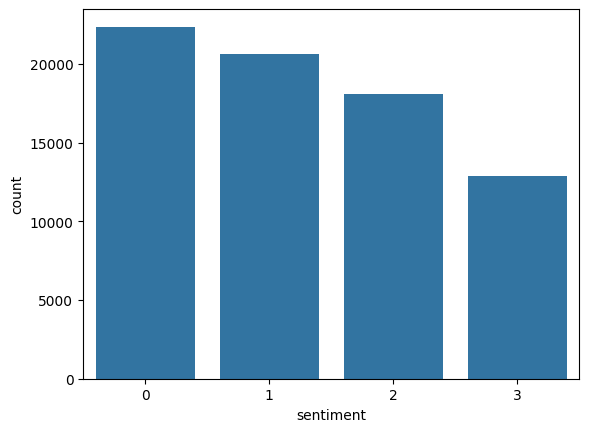

In [ ]:
sns.countplot(x = 'sentiment', data = tweet_df)

In [ ]:
fig = go.Figure(
    go.Funnelarea(
        text = ["Negative", "Positive", "Neutral", "Irrelevant"],
        values = tweet_df['sentiment'].value_counts().values,
        title = {"position": "top center", "text": "Sentiment Distribution"}
    )
)

fig.show()

In [ ]:
tweet_df['text'] = tweet_df['text'].str.lower()

In [ ]:
for index, text in enumerate(tweet_df['text'][:10]):
    print(index, text)
    print('-'*60)

0 im getting on borderlands and i will murder you all ,
------------------------------------------------------------
1 i am coming to the borders and i will kill you all,
------------------------------------------------------------
2 im getting on borderlands and i will kill you all,
------------------------------------------------------------
3 im coming on borderlands and i will murder you all,
------------------------------------------------------------
4 im getting on borderlands 2 and i will murder you me all,
------------------------------------------------------------
5 im getting into borderlands and i can murder you all,
------------------------------------------------------------
6 so i spent a few hours making something for fun. . . if you don't know i am a huge @borderlands fan and maya is one of my favorite characters. so i decided to make myself a wallpaper for my pc. . here is the original image versus the creation i made :) enjoy! pic.twitter.com/mlsi5wf9jg
------------

In [ ]:
# Dictionary of English Contractions
contractions_dict = { "ain't": "are not","'s":" is","aren't": "are not", "im" : "i am",
                     "can't": "cannot","can't've": "cannot have",
                     "'cause": "because","could've": "could have","couldn't": "could not",
                     "couldn't've": "could not have", "didn't": "did not","doesn't": "does not",
                     "don't": "do not","hadn't": "had not","hadn't've": "had not have",
                     "hasn't": "has not","haven't": "have not","he'd": "he would",
                     "he'd've": "he would have","he'll": "he will", "he'll've": "he will have",
                     "how'd": "how did","how'd'y": "how do you","how'll": "how will",
                     "I'd": "I would", "I'd've": "I would have","I'll": "I will",
                     "I'll've": "I will have","I'm": "I am","I've": "I have", "isn't": "is not",
                     "it'd": "it would","it'd've": "it would have","it'll": "it will",
                     "it'll've": "it will have", "let's": "let us","ma'am": "madam",
                     "mayn't": "may not","might've": "might have","mightn't": "might not",
                     "mightn't've": "might not have","must've": "must have","mustn't": "must not",
                     "mustn't've": "must not have", "needn't": "need not",
                     "needn't've": "need not have","o'clock": "of the clock","oughtn't": "ought not",
                     "oughtn't've": "ought not have","shan't": "shall not","sha'n't": "shall not",
                     "shan't've": "shall not have","she'd": "she would","she'd've": "she would have",
                     "she'll": "she will", "she'll've": "she will have","should've": "should have",
                     "shouldn't": "should not", "shouldn't've": "should not have","so've": "so have",
                     "that'd": "that would","that'd've": "that would have", "there'd": "there would",
                     "there'd've": "there would have", "they'd": "they would",
                     "they'd've": "they would have","they'll": "they will",
                     "they'll've": "they will have", "they're": "they are","they've": "they have",
                     "to've": "to have","wasn't": "was not","we'd": "we would",
                     "we'd've": "we would have","we'll": "we will","we'll've": "we will have",
                     "we're": "we are","we've": "we have", "weren't": "were not","what'll": "what will",
                     "what'll've": "what will have","what're": "what are", "what've": "what have",
                     "when've": "when have","where'd": "where did", "where've": "where have",
                     "who'll": "who will","who'll've": "who will have","who've": "who have",
                     "why've": "why have","will've": "will have","won't": "will not",
                     "won't've": "will not have", "would've": "would have","wouldn't": "would not",
                     "wouldn't've": "would not have","y'all": "you all", "y'all'd": "you all would",
                     "y'all'd've": "you all would have","y'all're": "you all are",
                     "y'all've": "you all have", "you'd": "you would","you'd've": "you would have",
                     "you'll": "you will","you'll've": "you will have", "you're": "you are",
                     "you've": "you have"}

# Regular expression for finding contractions
contractions_re=re.compile('(%s)' % '|'.join(contractions_dict.keys()))

# Function for expanding contractions
def expand_contractions(text,contractions_dict=contractions_dict):
  def replace(match):
    return contractions_dict[match.group(0)]
  return contractions_re.sub(replace, text)

tweet_df['preprocessed_text'] = tweet_df['text'].apply(lambda x: expand_contractions(x))

In [ ]:
for index, text in enumerate(tweet_df['preprocessed_text'][:10]):
  print(index, text)
  print('-'*60)

0 i am getting on borderlands and i will murder you all ,
------------------------------------------------------------
1 i am coming to the borders and i will kill you all,
------------------------------------------------------------
2 i am getting on borderlands and i will kill you all,
------------------------------------------------------------
3 i am coming on borderlands and i will murder you all,
------------------------------------------------------------
4 i am getting on borderlands 2 and i will murder you me all,
------------------------------------------------------------
5 i am getting into borderlands and i can murder you all,
------------------------------------------------------------
6 so i spent a few hours making something for fun. . . if you do not know i am a huge @borderlands fan and maya is one of my favorite characters. so i decided to make myself a wallpaper for my pc. . here is the original i amage versus the creation i made :) enjoy! pic.twitter.com/mlsi5wf9jg

In [ ]:
stop_words = set(stopwords.words('english'))

In [ ]:
tweet_df['preprocessed_text'] = tweet_df['preprocessed_text'].str.replace(r'[^a-zA-Z ]', '', regex=True).str.lower()
tweet_df['preprocessed_text'] = tweet_df['preprocessed_text'].apply(lambda x: ' '.join([word for word in x.split() if word not in stop_words]))

In [ ]:
for index, text in enumerate(tweet_df['preprocessed_text'][:10]):
  print(index, text)
  print('-'*60)

0 getting borderlands murder
------------------------------------------------------------
1 coming borders kill
------------------------------------------------------------
2 getting borderlands kill
------------------------------------------------------------
3 coming borderlands murder
------------------------------------------------------------
4 getting borderlands murder
------------------------------------------------------------
5 getting borderlands murder
------------------------------------------------------------
6 spent hours making something fun know huge borderlands fan maya one favorite characters decided make wallpaper pc original amage versus creation made enjoy pictwittercommlsiwfjg
------------------------------------------------------------
7 spent couple hours something fun know im huge borderlands fan maya one favorite characters decided make wallpaper pc original picture compared creation made fun pictwittercom mlsiwfjg
-------------------------------------------

In [ ]:
tweet_df.head()

sentiment                                               text  \
0          1  im getting on borderlands and i will murder yo...   
1          1  i am coming to the borders and i will kill you...   
2          1  im getting on borderlands and i will kill you ...   
3          1  im coming on borderlands and i will murder you...   
4          1  im getting on borderlands 2 and i will murder ...   

            preprocessed_text  
0  getting borderlands murder  
1         coming borders kill  
2    getting borderlands kill  
3   coming borderlands murder  
4  getting borderlands murder

In [ ]:
tweet_df_grouped = tweet_df[['sentiment', 'preprocessed_text']].groupby(by = 'sentiment').agg(lambda x: ' '.join(x))

In [ ]:
tweet_df_grouped.head()

preprocessed_text
sentiment                                                   
0          biggest dissappoinment life came year ago fuck...
1          getting borderlands murder coming borders kill...
2          rockhard la varlope rare powerful handsome jac...
3          appreciate sonic concepts praxis valenzuela la...

In [ ]:
tweet_df_grouped['preprocessed_text'][0]

'biggest dissappoinment life came year ago fuck borderlands biggest disappointment life came year ago biggest disappointment life came year ago biggest dissappoinment life coming year ago fuck borderlands biggest male dissappoinment life came hanging year ti ame ago fuck borderlands biggest dissappoinment life came back last year ago fuck borderlands last man gearbox really needs fix dissapointing drops new borderlands dlc cant fine farm bosses mayhem get legendary drop anywhere else get drops really sucks alot man gearbox really needs fix disappointing drops new borderlands dlc farm bosses mayhem get legendary drop get drops elsewhere man gearbox really needs fix disssapointing drops new borderlands dlc cant fine farm bosses mayhem get legendary drop elsewhere get drops really sucks alot man bethesda really needs fix dissapointing drops new borderlands cant fine farm bosses mayhem get legendary drop anywhere else get drops really sucks man gearbox really needs fix dissapointing drops 

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer(analyzer = 'word')
words = cv.fit_transform(tweet_df_grouped['preprocessed_text'])
df_words = pd.DataFrame(words.toarray(), columns = cv.get_feature_names_out())
df_words.index = tweet_df_grouped.index
df_words.head()


aa  aaa  aaaaaaaaaaaa  aaaaaaaaaaaaa  \
sentiment                                         
0           6   10             0              0   
1           0   11             1              3   
2           0    0             0              0   
3          80    7             0              0   

           aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa  \
sentiment                                                                                                                                                                                                
0                                                          0                                                                                                                                             
1                                                          1                                                                                                                                             
2                                                          0                                                                                                                                             
3                                                          0                                                                                                                                             

           aaaaaaaaaaages  aaaaaaaaaages  aaaaaasee  aaaahhh  aaarated  ...  \
sentiment                                                               ...   
0                       0              0          0        0         2  ...   
1                       4              1          0        0         0  ...   
2                       0              0          0        0         0  ...   
3                       0              0          1        6         0  ...   

           zyoten  zyotflen  zysola  zysolablogspotcom  \
sentiment                                                
0               0         0       0                  0   
1               1         1       0                  0   
2               0         0       1                  2   
3               0         0       0                  0   

           zysolablogspotcompwelcomehtml  zywzswpxq  zzgixvkt  zzmhpax  \
sentiment                                                                
0                                      0          2         2        0   
1                                      0          0         0        0   
2                                      3          0         0        0   
3                                      0          0         0        3   

           zzvfsrhewg  zzz  
sentiment                   
0                   1    1  
1                   0    0  
2                   0    0  
3                   0    0  

[4 rows x 38014 columns]

Tokenization

In [ ]:
df_words.columns

Index(['aa', 'aaa', 'aaaaaaaaaaaa', 'aaaaaaaaaaaaa',
       'aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa',
       'aaaaaaaaaaages', 'aaaaaaaaaages', 'aaaaaasee', 'aaaahhh', 'aaarated',
       ...
       'zyoten', 'zyotflen', 'zysola', 'zysolablogspotcom',
       'zysolablogspotcompwelcomehtml', 'zywzswpxq', 'zzgixvkt', 'zzmhpax',
       'zzvfsrhewg', 'zzz'],
      dtype='object', length=38014)

0 0


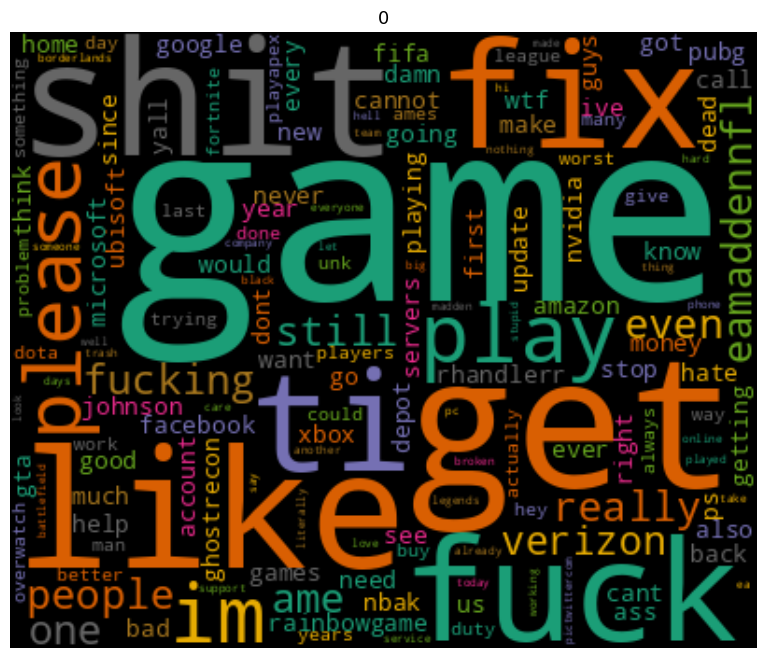

1 1


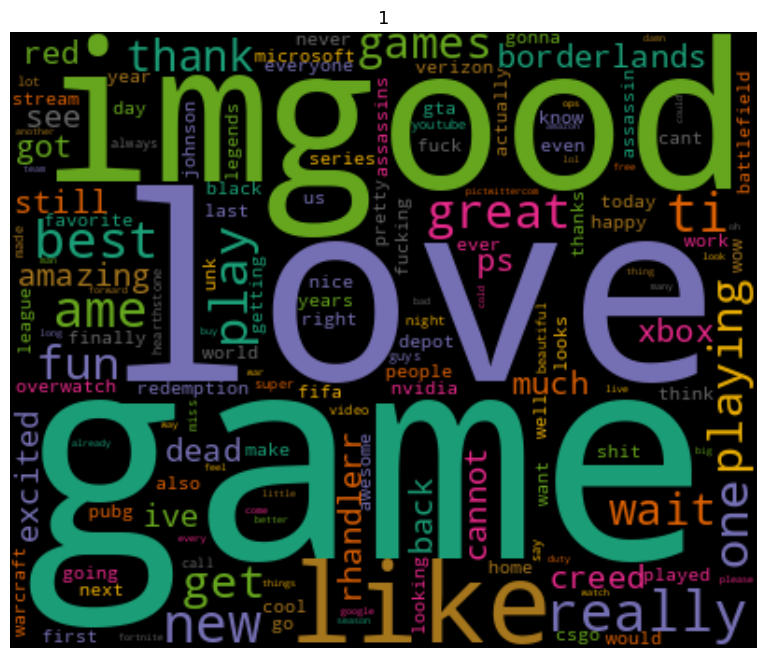

2 2


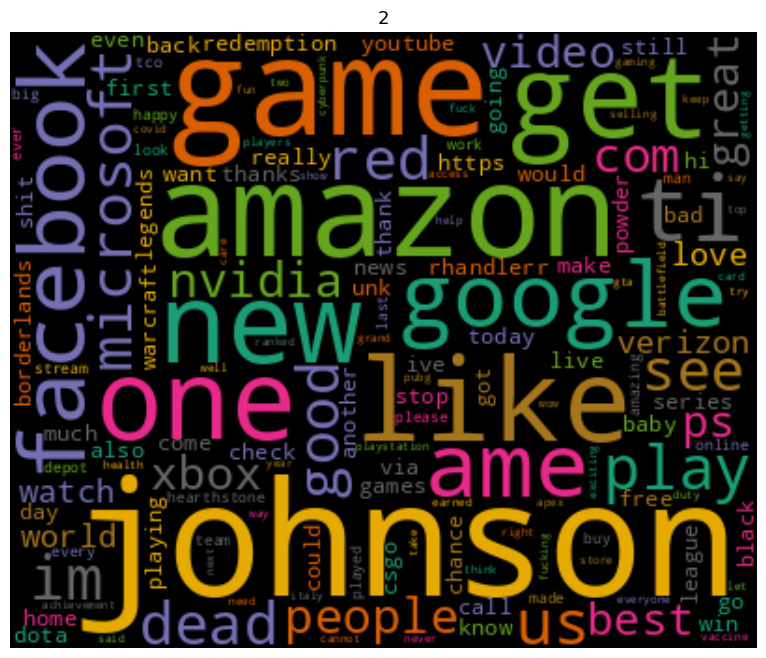

3 3


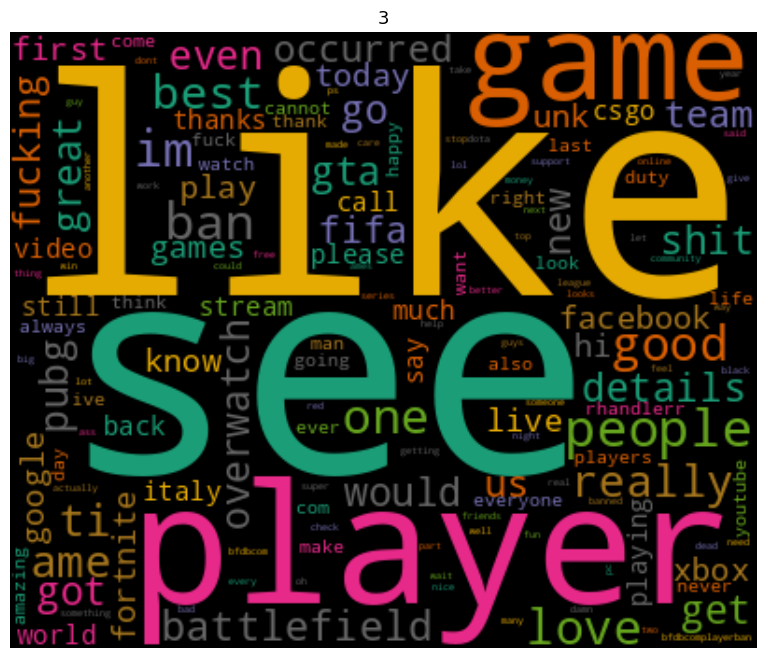

In [ ]:
# Importing wordcloud for plotting word clouds and textwrap for wrapping longer text
from wordcloud import WordCloud
from textwrap import wrap

# Function for generating word clouds
def generate_wordcloud(data, title):
  wc = WordCloud(width=400, height=330, max_words=150, colormap="Dark2").generate_from_frequencies(data)
  plt.figure(figsize=(10, 8))
  plt.imshow(wc, interpolation='bilinear')
  plt.axis("off")
  plt.title('\n'.join(wrap(str(title), 60)), fontsize=13) # Convert title to string before wrapping
  plt.show()

# Transposing document term matrix
df_words = df_words.transpose()

# Plotting word cloud for each product
for index, review in enumerate(df_words.columns):
  print(index, review)
  generate_wordcloud(df_words[review].sort_values(ascending=False), review)

top 20 reviews based on sentiment

In [ ]:
for index, review in enumerate(tweet_df[tweet_df['sentiment'] == 0]['text'][:20]):
  print(index, review)
  print('-'*60)

0 the biggest dissappoinment in my life came out a year ago fuck borderlands 3
------------------------------------------------------------
1 the biggest disappointment of my life came a year ago.
------------------------------------------------------------
2 the biggest disappointment of my life came a year ago.
------------------------------------------------------------
3 the biggest dissappoinment in my life coming out a year ago fuck borderlands 3
------------------------------------------------------------
4 for the biggest male dissappoinment in my life came hanging out a year time ago fuck borderlands 3
------------------------------------------------------------
5 the biggest dissappoinment in my life came back last year ago fuck borderlands last
------------------------------------------------------------
6 man gearbox really needs to fix this dissapointing drops in the new borderlands 3 dlc cant be fine to farm bosses on mayhem 10 to get 1 legendary drop while anywhere else 

In [ ]:
for index, review in enumerate(tweet_df[tweet_df['sentiment'] == 1]['text'][:10]):
  print(index, review)
  print('-'*60)

0 im getting on borderlands and i will murder you all ,
------------------------------------------------------------
1 i am coming to the borders and i will kill you all,
------------------------------------------------------------
2 im getting on borderlands and i will kill you all,
------------------------------------------------------------
3 im coming on borderlands and i will murder you all,
------------------------------------------------------------
4 im getting on borderlands 2 and i will murder you me all,
------------------------------------------------------------
5 im getting into borderlands and i can murder you all,
------------------------------------------------------------
6 so i spent a few hours making something for fun. . . if you don't know i am a huge @borderlands fan and maya is one of my favorite characters. so i decided to make myself a wallpaper for my pc. . here is the original image versus the creation i made :) enjoy! pic.twitter.com/mlsi5wf9jg
------------

In [ ]:
for index, review in enumerate(tweet_df[tweet_df['sentiment'] == 2]['text'][:10]):
  print(index, review)
  print('-'*60)

0 rock-hard la varlope, rare & powerful, handsome jackpot, borderlands 3 (xbox) dlvr.it/rmtrgf  
------------------------------------------------------------
1 rock-hard la varlope, rare & powerful, handsome jackpot, borderlands 3 (xbox) dlvr.it / rmtrgf
------------------------------------------------------------
2 rock-hard la varlope, rare & powerful, handsome jackpot, borderlands 3 (xbox) dfr.it / rmtrgf
------------------------------------------------------------
3 rock-hard la vita, rare but powerful, handsome jackpot, borderlands 1 (xbox) dlvr.it/rmtrgf
------------------------------------------------------------
4 live rock - hard music la la varlope, rare & the powerful, live handsome i jackpot, borderlands 3 ( sega xbox ) dlvr. from it / e rmtrgf
------------------------------------------------------------
5 i-hard like me, rare london de, handsome 2011, borderlands 3 (xbox) dlvr.it/rmtrgf
------------------------------------------------------------
6 check out this epic stre

In [ ]:
for index, review in enumerate(tweet_df[tweet_df['sentiment'] == 3]['text'][:10]):
  print(index, review)
  print('-'*60)

0 appreciate the (sonic) concepts / praxis valenzuela and landa-posas thread together in this talk: multimodal listening, soundwalks, borderlands frameworks, participatory action research, and testimonios. . . so many thoughtful and resonant intersections here.. .  
------------------------------------------------------------
1 appreciate the (sound) concepts / practices that valenzuela and landa-posas combine in this lecture: multimodal listening, soundwalks, borderland frameworks, participatory action research and testimonies... so many thoughtful and resonant intersections here...
------------------------------------------------------------
2 evaluate the (sound) concepts / concepts of valensela and landa pozas together in this conversation: multimodal listening, walks, border areas, joint action studies, etc. so many amazing and resonant intersections here...
------------------------------------------------------------
3 appreciate the (sonic) concepts / praxis valenzuela and moren

In [ ]:
tweet_df.head()

sentiment                                               text  \
0          1  im getting on borderlands and i will murder yo...   
1          1  i am coming to the borders and i will kill you...   
2          1  im getting on borderlands and i will kill you ...   
3          1  im coming on borderlands and i will murder you...   
4          1  im getting on borderlands 2 and i will murder ...   

            preprocessed_text  
0  getting borderlands murder  
1         coming borders kill  
2    getting borderlands kill  
3   coming borderlands murder  
4  getting borderlands murder

In [ ]:
# Load BERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = BertModel.from_pretrained('bert-base-uncased')

In [ ]:
from transformers import BertTokenizer, BertModel
import torch
import numpy as np
from tqdm import tqdm  # For progress tracking


tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = BertModel.from_pretrained('bert-base-uncased')
bert_model = bert_model.to('cuda')


def get_bert_embeddings_batch(text_list, batch_size=64):
    bert_model.eval()  # Set to evaluation mode (faster inference)
    embeddings = []

    for i in tqdm(range(0, len(text_list), batch_size)):  # Process in batches
        batch_texts = text_list[i:i + batch_size]
        tokens = tokenizer(batch_texts, return_tensors='pt', padding=True, truncation=True, max_length=128)

        # Move tensors to GPU/TPU if available
        tokens = {key: value.to('cuda') for key, value in tokens.items()}

        with torch.no_grad():
            output = bert_model(**tokens)

        batch_embeddings = output.last_hidden_state[:, 0, :].cpu().numpy()  # Extract [CLS] token embedding
        embeddings.append(batch_embeddings)

    return np.vstack(embeddings)


In [ ]:

# Convert text to BERT embeddings (Now runs much faster)
X = get_bert_embeddings_batch(tweet_df['preprocessed_text'].tolist(), batch_size=64)

# Convert labels to one-hot encoding
y = pd.get_dummies(tweet_df['sentiment']).values

100%|██████████| 1157/1157 [03:04<00:00,  6.29it/s]


In [ ]:
from imblearn.over_sampling import SMOTE
from collections import Counter


# Check class distribution
print("Original class distribution:", Counter(tweet_df['sentiment']))

# Apply SMOTE only on minority classes
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, tweet_df['sentiment'])

print("Resampled class distribution:", Counter(y_resampled))



Original class distribution: Counter({0: 22358, 1: 20655, 2: 18108, 3: 12875})
Resampled class distribution: Counter({1: 22358, 2: 22358, 0: 22358, 3: 22358})


<Axes: xlabel='sentiment', ylabel='count'>

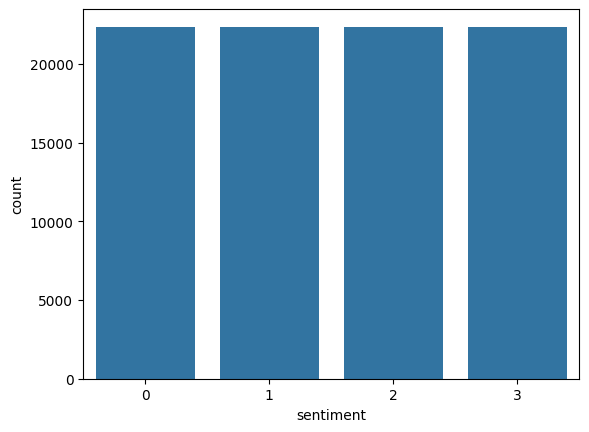

In [ ]:
sns.countplot(x = y_resampled)

In [ ]:
X_resampled

array([[-0.15305877, -0.03237846,  0.0531706 , ..., -0.05228374,
         0.09082196,  0.00895442],
       [-0.06754112,  0.178339  ,  0.06642754, ..., -0.26264018,
        -0.05328557, -0.05070625],
       [-0.10160676,  0.22265619, -0.11330763, ..., -0.16404745,
         0.06053258,  0.13233756],
       ...,
       [ 0.15174404,  0.0373893 ,  0.09399915, ..., -0.24093767,
         0.2137677 , -0.02437505],
       [-0.52053523, -0.20498858,  0.27587715, ..., -0.4038477 ,
         0.10357174,  0.5046177 ],
       [-0.53883094, -0.04396399,  0.11264009, ..., -0.21672508,
         0.04811946,  0.05089662]], dtype=float32)

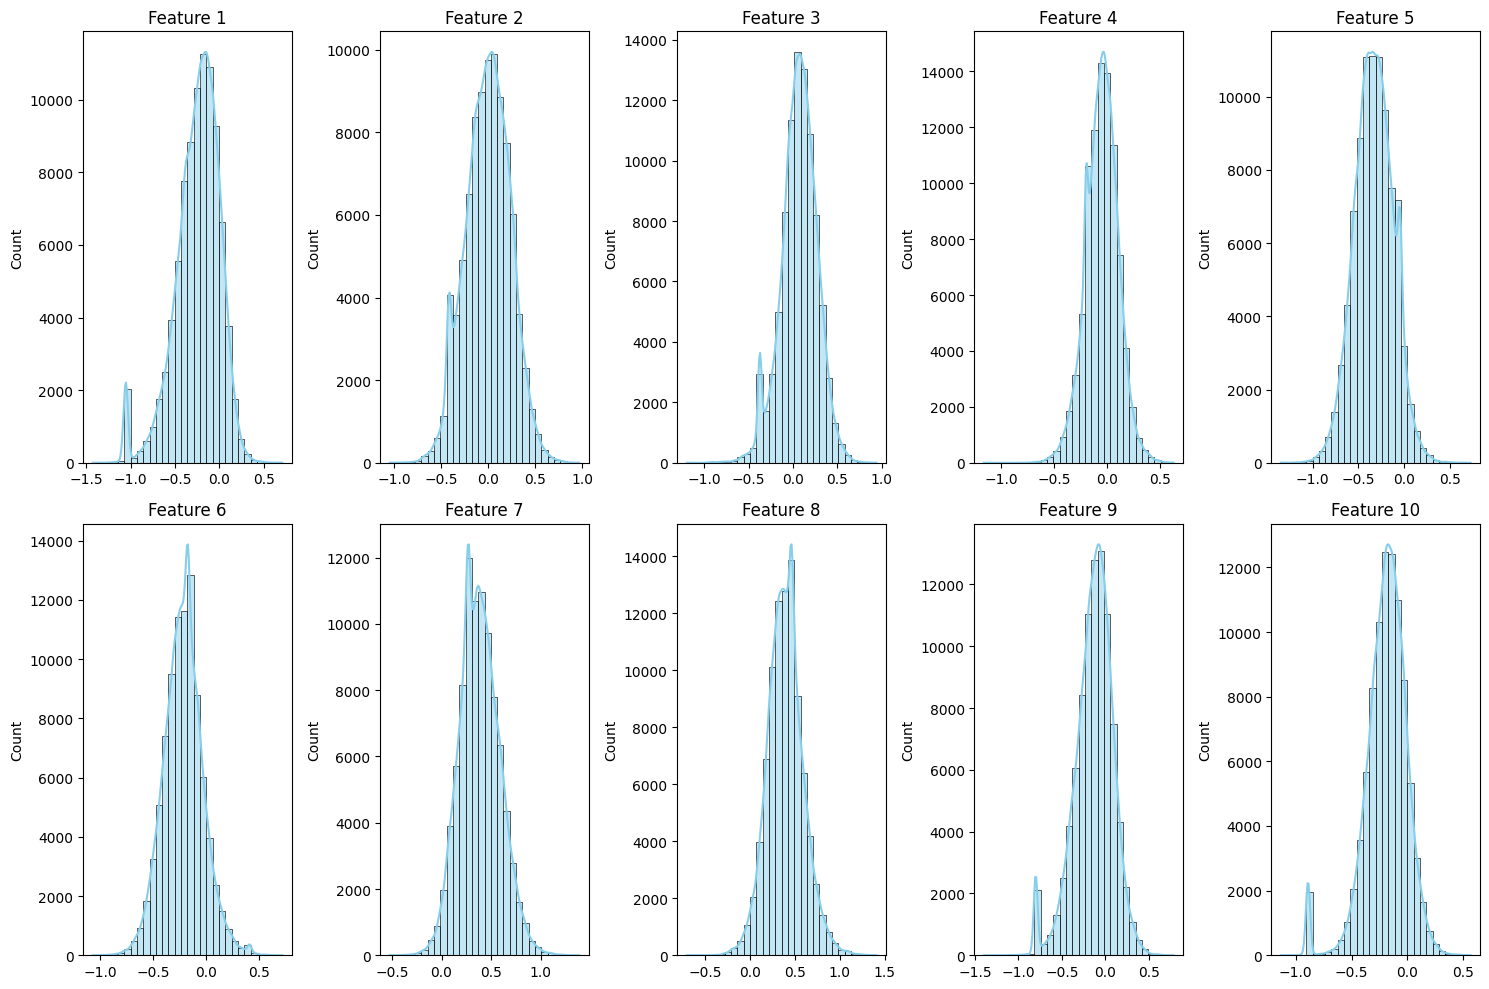

In [ ]:


# Example: Show distribution for first 10 features
num_features_to_plot = 10
plt.figure(figsize=(15, 10))

for i in range(num_features_to_plot):
    plt.subplot(2, 5, i+1)
    sns.histplot(X_resampled[:, i], kde=True, bins=30, color="skyblue")
    plt.title(f'Feature {i+1}')

plt.tight_layout()
plt.show()


In [ ]:
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)


In [ ]:

# Convert y_train and y_test to one-hot encoding
y_train = pd.get_dummies(y_train).values  # Convert y_train to one-hot
y_test = pd.get_dummies(y_test).values    # Convert y_test to one-hot



In [ ]:
X_train.shape

(71545, 768)

In [ ]:
model = Sequential([
    Dense(256, activation='relu', input_shape=(768,), kernel_regularizer=l2(0.01)),
    BatchNormalization(),
    Dropout(0.3),

    Dense(128, activation='relu', kernel_regularizer=l2(0.01)),
    BatchNormalization(),
    Dropout(0.3),

    Dense(64, activation='relu', kernel_regularizer=l2(0.01)),
    Dropout(0.3),

    Dense(4, activation='softmax')  # 4 classes (e.g., Negative, Neutral, Positive, Irrelevant)
])


In [ ]:
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_16 (Dense)                     │ (None, 256)                 │         196,864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_8                │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_12 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_17 (Dense)                     │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_9                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_13 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_18 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_14 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_19 (Dense)                     │ (None, 4)                   │             260 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 239,812 (936.77 KB)

 Trainable params: 239,044 (933.77 KB)

 Non-trainable params: 768 (3.00 KB)

In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=50,
    batch_size=128,
    callbacks=[early_stop, lr_scheduler]
)


Epoch 1/50
559/559 ━━━━━━━━━━━━━━━━━━━━ 15s 11ms/step - accuracy: 0.3207 - loss: 7.5456 - val_accuracy: 0.4617 - val_loss: 5.8588 - learning_rate: 1.0000e-04
Epoch 2/50
559/559 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.4128 - loss: 5.6321 - val_accuracy: 0.4864 - val_loss: 4.5209 - learning_rate: 1.0000e-04
Epoch 3/50
559/559 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.4526 - loss: 4.3303 - val_accuracy: 0.5001 - val_loss: 3.5222 - learning_rate: 1.0000e-04
Epoch 4/50
559/559 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.4791 - loss: 3.3717 - val_accuracy: 0.5170 - val_loss: 2.7948 - learning_rate: 1.0000e-04
Epoch 5/50
559/559 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5024 - loss: 2.6833 - val_accuracy: 0.5292 - val_loss: 2.2754 - learning_rate: 1.0000e-04
Epoch 6/50
559/559 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5120 - loss: 2.2005 - val_accuracy: 0.5228 - val_loss: 1.9280 - learning_rate: 1.0000e-04
Epoch 7/50
559/559 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy

In [ ]:
# prompt: save the model

model.save('sentiment_analysis_model.h5')

In [ ]:
# prompt: generate to classify sentiment on list of new reviews

import numpy as np
import pandas as pd
from tensorflow.keras.models import load_model
from transformers import BertTokenizer, BertModel
import torch
from tqdm import tqdm

# Load the saved model
model = load_model('sentiment_analysis_model.h5')

# Load BERT tokenizer and model (same as during training)
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = BertModel.from_pretrained('bert-base-uncased')
bert_model = bert_model.to('cuda')  # Move to GPU if available

def get_bert_embeddings_batch(text_list, batch_size=64):
    bert_model.eval()
    embeddings = []
    for i in tqdm(range(0, len(text_list), batch_size)):
        batch_texts = text_list[i:i + batch_size]
        tokens = tokenizer(batch_texts, return_tensors='pt', padding=True, truncation=True, max_length=128)
        tokens = {key: value.to('cuda') for key, value in tokens.items()}
        with torch.no_grad():
            output = bert_model(**tokens)
        batch_embeddings = output.last_hidden_state[:, 0, :].cpu().numpy()
        embeddings.append(batch_embeddings)
    return np.vstack(embeddings)

def preprocess_text(text):
    text = expand_contractions(text)
    text = re.sub(r'[^a-zA-Z ]', '', text).lower()
    new_text  = ' '.join([word for word in text.split() if word not in stop_words])
    return new_text  # Replace with actual preprocessed text

# Example new reviews
new_reviews = [
    "This is a great product!",
    "I absolutely hate this!",
    "It's okay, nothing special.",
    "I'm not sure about this one.",
    "best movie to watch",
    "i love this movie",
    "fuck what a boring movie",
    "why sky is blue not blavk or red",
    "blah blah blaaaaaaaaaaaaaaaaaaaaaaaaa",
    "This movie was absolutely amazing! I loved every moment of it.",
    "It was an average film, nothing too special.",
    "I hated this movie. Worst experience ever!",
    "Wonderful movie I loved it super hit movie",
    "Greatest movie of the decay",
    "good movie",
    "I love ice cream",
    "Mumbai is the capital of Maharashtra",
    "football is even better than cricket",
    "waste of time watching this movie"
]

# Preprocess the new reviews
preprocessed_reviews = [preprocess_text(review) for review in new_reviews]

# Generate BERT embeddings for the new reviews
new_review_embeddings = get_bert_embeddings_batch(preprocessed_reviews)

# Predict sentiment for the new reviews
predictions = model.predict(new_review_embeddings)

# Get predicted sentiment labels (assuming classes 0, 1, 2, 3)
predicted_labels = np.argmax(predictions, axis=1)

# Print the results
for i, review in enumerate(new_reviews):
    print(f"Review: {review}")
    print(f"Predicted Sentiment: {predicted_labels[i]}")
    print("-" * 20)


100%|██████████| 1/1 [00:00<00:00, 25.47it/s]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 342ms/step
Review: This is a great product!
Predicted Sentiment: 1
--------------------
Review: I absolutely hate this!
Predicted Sentiment: 0
--------------------
Review: It's okay, nothing special.
Predicted Sentiment: 2
--------------------
Review: I'm not sure about this one.
Predicted Sentiment: 2
--------------------
Review: best movie to watch
Predicted Sentiment: 1
--------------------
Review: i love this movie
Predicted Sentiment: 1
--------------------
Review: fuck what a boring movie
Predicted Sentiment: 0
--------------------
Review: why sky is blue not blavk or red
Predicted Sentiment: 1
--------------------
Review: blah blah blaaaaaaaaaaaaaaaaaaaaaaaaa
Predicted Sentiment: 0
--------------------
Review: This movie was absolutely amazing! I loved every moment of it.
Predicted Sentiment: 1
--------------------
Review: It was an average film, nothing too special.
Predicted Sentiment: 1
--------------------
Review: I hated this movie. Worst experie

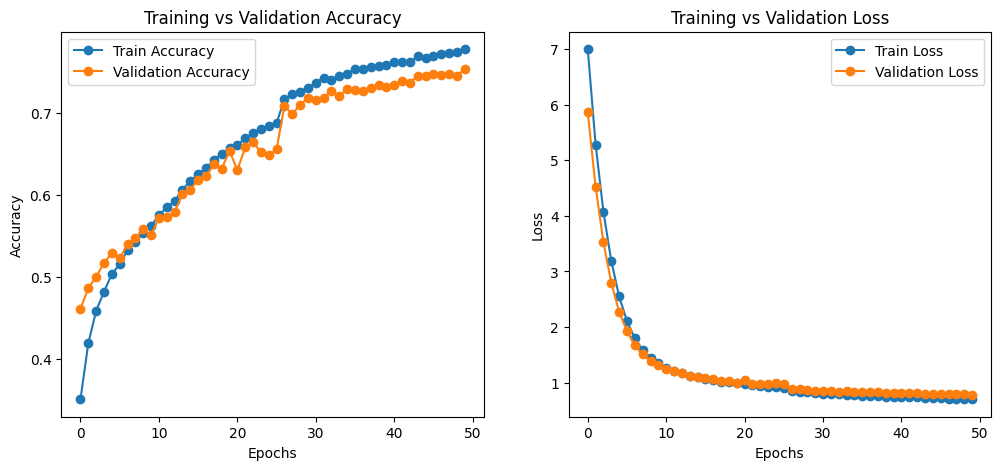

In [ ]:
# Plot accuracy
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss', marker='o')
plt.plot(history.history['val_loss'], label='Validation Loss', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()

plt.show()